<a href="https://colab.research.google.com/github/codebylakshay/ProJect-1/blob/main/Movie_Genre_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'wikipedia-movie-plots:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F64890%2F127736%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240831%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240831T070659Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3dffcb4ad591e89d3fea9da05601914463902b2f5cdd2144050a99a0f3c8988c087b51df8d18e10c55d43b76d92e1ef6281011640fd72438af8013d84305ea3f72da8fe5a2d7b455b79e1450173bc2a5a8bff94b8a09f6f66d554816c04d6d296287434f4f63a42d64fa989340f147f8367a0c1baacf4ccc3b8551fa7cbdd7dc245e6700ff086cc62a622cf0a91ec6e620aed06f5d3fbfc39a635626283e774de2e7c56fa27e6d03b00f5748a563888a0844938708c10c07b0da2cd6d2d0fec4a37953c25544bc09ca7f3dede1739aeb325222a265c8da9eb841e98dae4eb513a48ed3aecc8e6fd42b9da9162f6f9a7fb1d50a4ff0fbc5290b1ee26b6d521b59'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Genre Prediction
In this notebook, we will attempt to predict the genre of movies using their plots and different approaches

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re, spacy, torch
from keras.preprocessing import sequence

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, ComplementNB

In [ ]:
plots_df = pd.read_csv("/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv")
plots_df.shape

(34886, 8)

## Attribute distributions
Most movies seem to be recent, with only a few before the 1940s. Most are also American in origin.

array([[<AxesSubplot:title={'center':'Release Year'}>]], dtype=object)

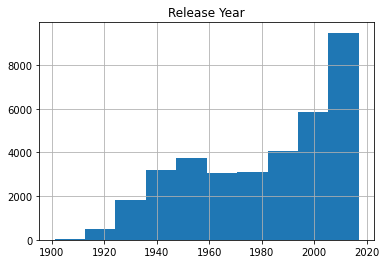

In [ ]:
plots_df.hist(column='Release Year')

<AxesSubplot:>

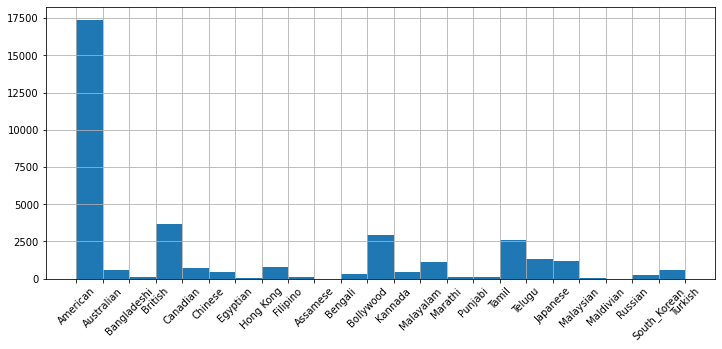

In [ ]:
plots_df['Origin/Ethnicity'].hist(xrot=45, figsize=(12,5),bins=len(plots_df['Origin/Ethnicity'].unique()) -1)

## Target Formatting
In order to clean up the target variable, some processing is required. By examining the dataset, some common genres are annotated in different ways. We will normalize them below using special tokenization rules.

In [ ]:
nlp = spacy.load("en_core_web_sm")

infixes = nlp.Defaults.infixes + [r'[/\[\]]']
infix_regex = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_regex.finditer

special_cases = {
    "sci-fi": [{'ORTH':'sci-','NORM':'science'},{'ORTH':'fi','NORM':'fiction'}],
    "sci fi": [{'ORTH':'sci ','NORM':'science'},{'ORTH':'fi','NORM':'fiction'}],
    "romcom": [{'ORTH':'rom','NORM':'romance'},{'ORTH':'com','NORM':'comedy'}],
    "rom-com": [{'ORTH':'rom-','NORM':'romance'},{'ORTH':'com','NORM':'comedy'}],
    "rom com": [{'ORTH':'rom ','NORM':'romance'},{'ORTH':'com','NORM':'comedy'}],
    "biopic": [{'ORTH':'bio','NORM':'biography'},{'ORTH':'pic','NORM':'film'}],
    "bio-pic": [{'ORTH':'bio-','NORM':'biography'},{'ORTH':'pic','NORM':'film'}],
    "dramedy": [{'ORTH':'dram','NORM':'drama'},{'ORTH':'edy','NORM':'comedy'}],
    "docudrama": [{'ORTH':'docu','NORM':'documentary'},{'ORTH':'drama','NORM':'drama'}],
}

tokenizer = nlp.tokenizer
for text, attrs in special_cases.items():
    tokenizer.add_special_case(text,attrs)

norm_patterns = [
    {
        "patterns" : [[{"LOWER":"romantic"}]],
        "attrs": {"NORM":"romance"}
    },
    {
        "patterns" : [[{"LOWER":"biographical"}]],
        "attrs": {"NORM" : "biography"}
    }
]
ruler = nlp.get_pipe("attribute_ruler")
ruler.add_patterns(norm_patterns)


class GenreMerger(object):
    def __init__(self, nlp, patterns):
        self.patterns = patterns
        self.nlp = nlp
        self.matcher = spacy.matcher.Matcher(nlp.vocab)
        for pat_id, pattern in patterns.items():
            self.matcher.add(pat_id, [pattern])

    def __call__(self, doc):
        matches = self.matcher(doc)
        spans = [doc[start:end] for match_id, start, end in matches]
        with doc.retokenize() as retokenizer:
            for match_id, start, end in matches:
                match_patterns = self.patterns[self.nlp.vocab.strings[match_id]]
                norm = " ".join([pattern["NORM"] for pattern in match_patterns if "NORM" in pattern])

                retokenizer.merge(doc[start:end], attrs={"NORM": norm})
        return doc


@spacy.Language.factory("genre_merger", retokenizes=True)
def merger_factory(nlp, name):
    merge_patterns = {
        "sci-fi" : [{'NORM':'science'},{"IS_PUNCT": True, "OP":"?"},{'NORM':'fiction'}],
        "ww" : [{'NORM':'world'},{'NORM':'war'}],
        "martial_arts" : [{'NORM':'martial'},{'NORM':'arts'}]
    }
    return GenreMerger(nlp, merge_patterns)

nlp.add_pipe("genre_merger")

In [ ]:
genres = nlp.pipe(plots_df['Genre'], disable=['tok2vec','ner'])
genres = pd.Series([[token.norm_ for token in doc if not token.is_punct] for doc in genres])

## Target distribution
Few of the genres are the most commonly occuring, with drama and comedy taking the lead. Furthermore, a significant portion of the genres is unknown.

<BarContainer object of 35 artists>

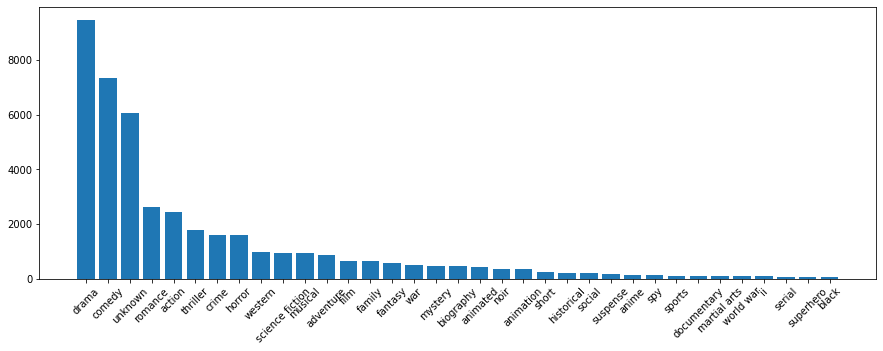

In [ ]:
genre_count = genres.explode().value_counts()
subset = genre_count[:35]

plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
plt.bar(subset.index,subset)

Because of this distribution, we will only keep the most common genres, and skip the missing ones for now. To help boost the less frequent genres, we will only keep the genre with the least overall representation from each movie's genre list.

In [ ]:
def get_top_genres(top_n):
    return genre_count[genre_count.index != 'unknown'][:top_n].index

def determine_genre(genre_list, top_genres):
    for genre in top_genres[::-1]:
        if genre in genre_list:
            return genre
    return "other"

(array([10655.,   966.,  5561.,  6947.,  1542.,  1585.,  1957.,  2241.,
         1535.,  1897.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

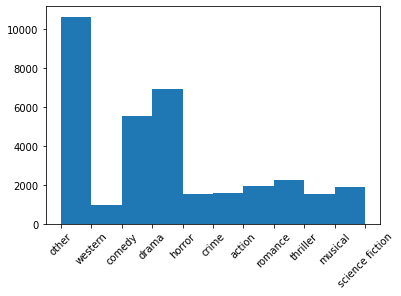

In [ ]:
classes = get_top_genres(10)
targets = genres.apply(determine_genre,top_genres=classes)

plt.xticks(rotation=45)
plt.hist(targets, bins=10)

Our first attempt at prediction will vectorize the plots using simple BoW weighting, and classify the genres using a multinomial Naive Bayes classifier.

In [ ]:
plots_df['class'] = targets
data = plots_df[plots_df['class'] != 'other'][['Plot','Title','class']]
train_x, test_x, train_y, test_y =  train_test_split(data['Plot'], data['class'], shuffle=True, random_state=1)

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='unicode', stop_words='english')),
    ('classifier', MultinomialNB())
])

pipeline.fit(train_x, train_y)

y_pred = pipeline.predict(test_x)
print(classification_report(test_y, y_pred))

                 precision    recall  f1-score   support

         action       0.46      0.46      0.46       465
         comedy       0.50      0.65      0.56      1396
          crime       0.56      0.31      0.40       407
          drama       0.55      0.60      0.57      1749
         horror       0.68      0.71      0.69       380
        musical       0.59      0.08      0.14       218
        romance       0.38      0.42      0.40       563
science fiction       0.67      0.63      0.65       234
       thriller       0.45      0.17      0.25       402
        western       0.94      0.70      0.80       244

       accuracy                           0.53      6058
      macro avg       0.58      0.47      0.49      6058
   weighted avg       0.54      0.53      0.52      6058



Not bad for such a simplistic approach! It's interesting to note that science fiction and western achieved such high precision, there are probably words that are highly indicative of the genre such as "spaceship" or "cowboy". Like the example below!

In [ ]:
pipeline.predict([
    "Tom is a cowboy in Texas and tries his hand at bounty hunting.",
    "Jenny boards the spaceship and travels to Mars in an attempt to escape the aliens."
])

array(['western', 'science fiction'], dtype='<U15')

## LSTM with vector embeddings
Our next approach will be to feed the vector embeddings of the plot tokens into an LSTM RNN. We'll need the embeddings from SpaCy. Also after examination of the dataset we'll also need to add the infix punctuation we used earlier.

In [ ]:
spacy.cli.download("en_core_web_md")
nlp_md = spacy.load("en_core_web_md")
nlp_md.tokenizer.infix_finditer = infix_regex.finditer

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Tokenization is going to take some time, because it also includes POS lemmatization

In [ ]:
plots = nlp_md.pipe(plots_df['Plot'],disable=['parser','ner'], batch_size=100, n_process=3)

log_interval = 1000

plots_tokenized = []
for doc in plots:
    tokens = []
    for token in doc:
        if token.is_alpha and not token.is_stop:
            tokens.append(token.lemma_.lower())
    plots_tokenized.append(tokens)
    if len(plots_tokenized) % log_interval == 0:
        print(f"Tokenized {len(plots_tokenized)} plots")

Tokenized 1000 plots
Tokenized 2000 plots
Tokenized 3000 plots
Tokenized 4000 plots
Tokenized 5000 plots
Tokenized 6000 plots
Tokenized 7000 plots
Tokenized 8000 plots
Tokenized 9000 plots
Tokenized 10000 plots
Tokenized 11000 plots
Tokenized 12000 plots
Tokenized 13000 plots
Tokenized 14000 plots
Tokenized 15000 plots
Tokenized 16000 plots
Tokenized 17000 plots
Tokenized 18000 plots
Tokenized 19000 plots
Tokenized 20000 plots
Tokenized 21000 plots
Tokenized 22000 plots
Tokenized 23000 plots
Tokenized 24000 plots
Tokenized 25000 plots
Tokenized 26000 plots
Tokenized 27000 plots
Tokenized 28000 plots
Tokenized 29000 plots
Tokenized 30000 plots
Tokenized 31000 plots
Tokenized 32000 plots
Tokenized 33000 plots
Tokenized 34000 plots


Next, we need to find the vector index for each word in order for it to be fed to the embedding layer.

In [ ]:
vectors = nlp_md.vocab.vectors
plots_ind = [ [vectors.find(key=word) for word in plot if vectors.find(key=word) > -1] for plot in plots_tokenized]

plots_series = pd.Series(plots_ind)
plots_series.apply(len).describe()

count    34886.000000
mean       185.250043
std        155.236456
min          1.000000
25%         61.000000
50%        141.000000
75%        289.000000
max       3127.000000
dtype: float64

After examining the distribution of sequence lengths, we select a length so that we cover most of the available text

In [ ]:
plots_padded = sequence.pad_sequences(plots_ind, maxlen=350, padding='post',truncating='post')

This time we'll try a multi-label approach, using more genres. We'll remove the datapoints that don't include any of the selected genres. This still leaves us with a lot of datapoints.

In [ ]:
target_classes = get_top_genres(35)
binarizer = MultiLabelBinarizer(classes=target_classes)
target_vectors = binarizer.fit_transform(genres)

non_zero = (target_vectors != 0).any(axis=1)
X = torch.tensor(plots_padded[non_zero],dtype=torch.long)
y = torch.tensor(target_vectors[non_zero], dtype= torch.float)

X.shape

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:995: UserWarning: unknown class(es) [' ', '  ', "'s", '007', '1', '140', '144', '16', '18', '2', '25', '3', '30min', '3d', '4,000', '6', '9', 'a', 'about', 'acclaimed', 'adaptation', 'adapted', 'adult', 'adventures', 'afghan', 'african', 'agarwal', 'age', 'ago', 'ahlawat', 'aids', 'ajay', 'alexandre', 'ali', 'alice', 'allari', 'alzheimer', 'american', 'amperiani', 'ancient', 'and', 'anthology', 'anushka', 'apocalyptic', 'aquatics', 'arctic', 'arjun', 'art', 'arti', 'artistic', 'artists', 'arts', 'arya', 'asin', 'aswani', 'august', "auli'i", 'australian', 'avant', 'aviation', 'b', 'b.r', 'babu', 'bajwa', 'balaji', 'balakrishna', 'ballard', 'balu', 'banks', 'barua', 'based', 'bbc', 'bernard', 'bhagavaan', 'bharath', 'bhaskara', 'bhavana', 'bholenath', 'bhoomika', 'biblical', 'bicycle', 'biju', 'biker', 'bio', 'biodrama', 'biographic', 'biogtaphy', 'biopic', 'blaxploitation', 'board', 'bond', 'bouchard', 'boxing', 'bra

torch.Size([28166, 350])

In [ ]:
dataset = torch.utils.data.dataset.TensorDataset(X,y)

# Fixed generator for reproducible results
random_generator = torch.Generator().manual_seed(1)

train_percent = 0.7
train_size = int(train_percent * X.shape[0])
test_size = X.shape[0] - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=random_generator)

batch_size = 100
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=random_generator)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Our Model will only contain the embedding layer, a recurrent layer for which we will keep 128 hidden units, and a linear layer for the final classification

In [ ]:
class GenreModel(torch.nn.Module):

    def __init__(self, embeddings, num_hidden, num_output):
        super(GenreModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(torch.Tensor(embeddings))
        self.recurrent = torch.nn.LSTM(input_size=embeddings.shape[1], hidden_size=num_hidden, batch_first=True)
        self.dense = torch.nn.Linear(in_features=num_hidden, out_features=num_output)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        output, (h_n, c_n) = self.recurrent(x)
        x = self.dense(h_n)
        x = self.softmax(x)
        return x

embeddings = nlp_md.vocab.vectors.data
model = GenreModel(embeddings,128, y.shape[1])

Because we have a multi-label target we'll use binary cross entropy for the loss function.

In [ ]:
logging_batch = 10

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred[0], y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % logging_batch == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred[0], y).item()

    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1
loss: 0.179303  [    0/19716]
loss: 0.196608  [ 1000/19716]
loss: 0.171056  [ 2000/19716]
loss: 0.180773  [ 3000/19716]
loss: 0.171566  [ 4000/19716]
loss: 0.188087  [ 5000/19716]
loss: 0.179009  [ 6000/19716]
loss: 0.177580  [ 7000/19716]
loss: 0.188737  [ 8000/19716]
loss: 0.175526  [ 9000/19716]
loss: 0.169589  [10000/19716]
loss: 0.179002  [11000/19716]
loss: 0.172252  [12000/19716]
loss: 0.153360  [13000/19716]
loss: 0.165332  [14000/19716]
loss: 0.182451  [15000/19716]
loss: 0.170022  [16000/19716]
loss: 0.170957  [17000/19716]
loss: 0.174491  [18000/19716]
loss: 0.168530  [19000/19716]
Test Error: Avg loss: 0.170464 

Epoch 2
loss: 0.175180  [    0/19716]
loss: 0.168580  [ 1000/19716]
loss: 0.157374  [ 2000/19716]
loss: 0.174554  [ 3000/19716]
loss: 0.152841  [ 4000/19716]
loss: 0.158400  [ 5000/19716]
loss: 0.163257  [ 6000/19716]
loss: 0.179514  [ 7000/19716]
loss: 0.161235  [ 8000/19716]
loss: 0.168388  [ 9000/19716]
loss: 0.165557  [10000/19716]
loss: 0.147325  [1100